In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import seaborn as sns

In [3]:
CSV_IN = 'datos/Base datos_INTA_ascii_limpio.csv'
CLIMA_CSV_IN = 'datos/Base datos_INTA_ascii_limpio.csv'

df = pd.read_csv(CSV_IN, index_col='id', parse_dates=True)
print 'Cargado dataframe de tamaño %d filas x %d columnos de "%s"' % (df.shape[0], df.shape[1], CSV_IN)
clima = pd.read_csv('datos/clima_datos_unidos.csv', index_col='Date', parse_dates=True)
print 'Cargado dataframe de tamaño %d filas x %d columnos de "%s"' % (clima.shape[0], clima.shape[1], CLIMA_CSV_IN)

clima['TAVG'] = (clima['TMAX'] + clima['TMIN']) / 2.0
clima.head(3)

Cargado dataframe de tamaño 423 filas x 34 columnos de "datos/Base datos_INTA_ascii_limpio.csv"
Cargado dataframe de tamaño 2922 filas x 5 columnos de "datos/Base datos_INTA_ascii_limpio.csv"


,ESOL,RAIN,RHUM,TMAX,TMIN,TAVG
Date,,,,,,
2006-01-01,22.4,0,60,29.5,19,24.25
2006-01-02,24.3,0,76,37.2,21,29.10
2006-01-03,20.0,0,63,34.2,17,25.60


In [4]:
# Borrar filas con fechas invalidas
fecha_cols = []
for c in df.columns:
    if 'fecha' in c:
        fecha_cols.append(c)
        df[c] = pd.to_datetime(df[c]).astype('datetime64[ns]')

# df[['fenologia_cosecha_fecha','fenologia_siembra_fecha']].head()
df['dias_siembra_cosecha'] = (df['fenologia_cosecha_fecha'] - df['fenologia_siembra_fecha']).apply(
    lambda dt: dt / np.timedelta64(24, 'h'))
antes = len(df)
df = df[df['dias_siembra_cosecha'] < 365]
df = df[pd.notnull(df['dias_siembra_cosecha'])]
print 'Borrando %d/%d filas invalidas, quedan %d' % (antes - len(df), antes, len(df))

Borrando 41/423 filas invalidas, quedan 382


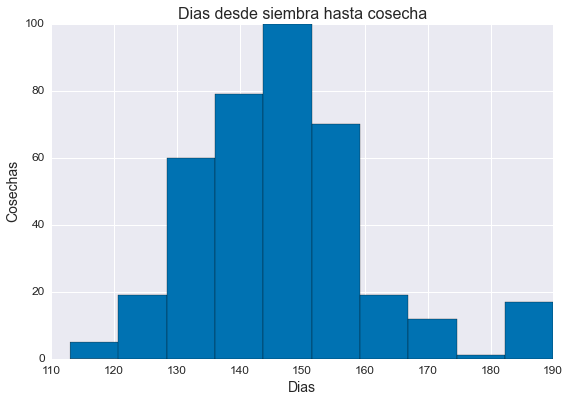

In [5]:
fig, ax = plt.subplots(1)
ax.hist(df['dias_siembra_cosecha'])
ax.set_title('Dias desde siembra hasta cosecha')
ax.set_xlabel('Dias')
ax.set_ylabel('Cosechas')

In [6]:
def computar_clima_critical_frac(tmin, tmax):
    clima_critical_frac = []
    for siembra, cosecha in zip(df['fenologia_siembra_fecha'], df['fenologia_cosecha_fecha']):
        dias_cultivos = clima[siembra:cosecha]
        criticales = ((dias_cultivos['TMAX'] <= tmax) & (dias_cultivos['TMIN'] >= tmin)).sum()
#         criticales = ((dias_cultivos['TAVG'] <= tmax) & (dias_cultivos['TAVG'] >= tmin)).sum()
        clima_critical_frac.append(criticales * 1.0 / len(dias_cultivos))
    df['clima_critical_frac'] = clima_critical_frac

In [57]:
TEMPS_20 = range(0, 41, 2)
TEMPS_40 = range(0, 41)

ORDEN_FIT = 2
TEMPS = TEMPS_20
all_rows = []
for tmin in TEMPS:
    row = []
    for tmax in TEMPS:
        if tmax <= tmin:
            r, p = 0.0, 1.0
        else:
            computar_clima_critical_frac(tmin, tmax)
            if ((df['clima_critical_frac'] > 0).sum() == 0 or
                (df['clima_critical_frac'] < 1).sum() == 0):
                r, p = 0.0, 1.0
            else:
                coeffs = np.polyfit(df['clima_critical_frac'], df['rendimiento_seco_kg_ha'], ORDEN_FIT)
                f = np.poly1d(coeffs)
                pred = f(df['clima_critical_frac'].values)
                r, p = pearsonr(pred, df['rendimiento_seco_kg_ha'].values)
                if ORDEN_FIT == 1 and coeffs[0] < 0:
                    r = -r
                if np.isnan(r):
                    r, p = 0, 1
            print tmin, tmax, '%.4f %.4f' % (r, p)
        row.append(r)
    all_rows.append(row)

vals = []
for i in range(len(TEMPS)):
    for j in range(len(TEMPS)):
        vals.append([TEMPS[i], TEMPS[j], all_rows[i][j]])

vals.sort(key = lambda v: -abs(v[-1]))
for v in vals[:20]:
    print v

0 2 0.0000 1.0000
0 4 0.0000 1.0000
0 6 0.0000 1.0000
0 8 0.0000 1.0000
0 10 0.1479 0.0038
0 12 0.0775 0.1305
0 14 0.1279 0.0123
0 16 0.1183 0.0208
0 18 0.0908 0.0764
0 20 0.1487 0.0036
0 22 0.0372 0.4689
0 24 0.1065 0.0374
0 26 0.1988 0.0001
0 28 0.2090 0.0000
0 30 0.0679 0.1856
0 32 0.1476 0.0038
0 34 0.1791 0.0004
0 36 0.4230 0.0000
0 38 0.2845 0.0000
0 40 0.1421 0.0054
2 4 0.0000 1.0000
2 6 0.0000 1.0000
2 8 0.0000 1.0000
2 10 0.0000 1.0000
2 12 0.1869 0.0002
2 14 0.1829 0.0003
2 16 0.1516 0.0030
2 18 0.2850 0.0000
2 20 0.0684 0.1824
2 22 0.1597 0.0017
2 24 0.1641 0.0013
2 26 0.2541 0.0000
2 28 0.2641 0.0000
2 30 0.0913 0.0746
2 32 0.1224 0.0167
2 34 0.1648 0.0012
2 36 0.4394 0.0000
2 38 0.2207 0.0000
2 40 0.1132 0.0270
4 6 0.0000 1.0000
4 8 0.0000 1.0000
4 10 0.0000 1.0000
4 12 0.1869 0.0002
4 14 0.1829 0.0003
4 16 0.0427 0.4056
4 18 0.1383 0.0068
4 20 0.1694 0.0009
4 22 0.1027 0.0449
4 24 0.1405 0.0060
4 26 0.2135 0.0000
4 28 0.2050 0.0001
4 30 0.0677 0.1868
4 32 0.1455 0.0044
4 

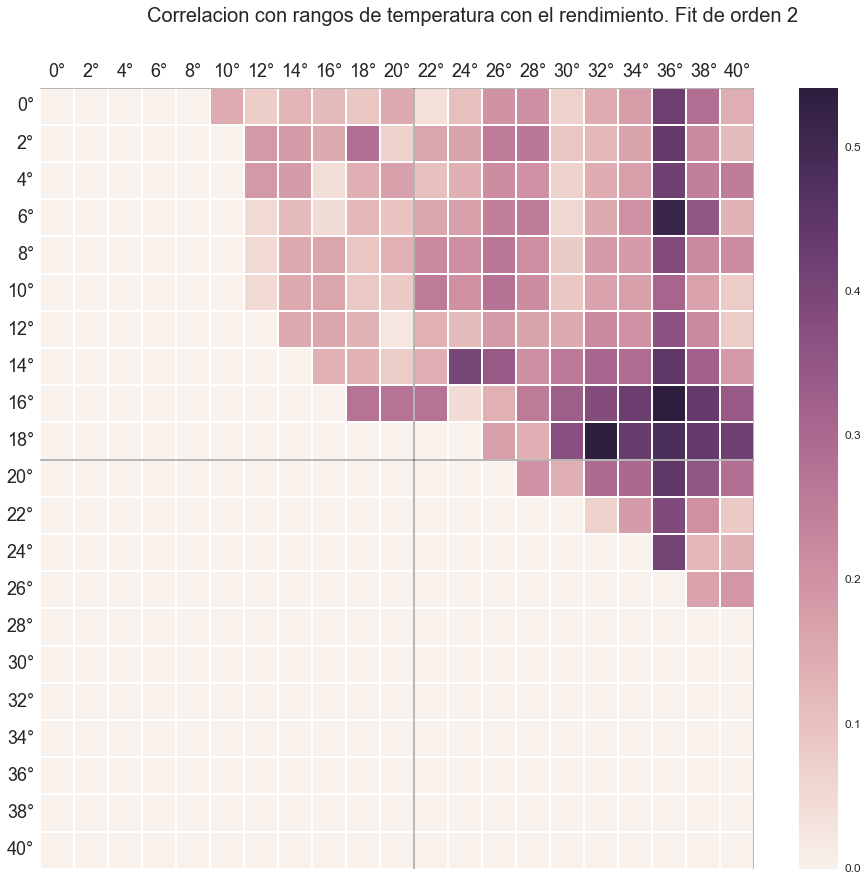

In [58]:
# all_rows_20 = all_rows
# all_rows_40 = all_rows
# all_rows, TEMPS = all_rows_20, TEMPS_20
# all_rows, TEMPS = all_rows_40, TEMPS_40

temps_with_deg = [u'%d°' % t for t in TEMPS]
hotframe = pd.DataFrame(all_rows, index=TEMPS, columns=TEMPS)


fig, ax = plt.subplots(1)
fig.set_size_inches(16, 14)
sns.heatmap(hotframe, ax=ax)
fontsize = 11 if (TEMPS[1] == 1) else 18
for value in range(11,41,10):
    alpha = 0.33
    color = 'black'
    linestyle = '-'
    xy = [min(hotframe.index.values), 1 + max(hotframe.index.values)]
    ax.plot([value, value], xy, alpha=alpha, color=color, linestyle=linestyle)
    ax.plot(xy, [value, value], alpha=alpha, color=color, linestyle=linestyle)

if TEMPS[1] == 2:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(35)
ax.xaxis.tick_top()
ax.set_xticklabels([u'%s°' % t.get_text() for t in ax.get_xticklabels()], rotation=0, fontsize=fontsize)
ax.set_yticklabels([u'%s°' % t.get_text() for t in ax.get_yticklabels()], rotation=0, fontsize=fontsize)
filename = 'figuras/heatmap_temp_%dorden_step%dc.png' % (ORDEN_FIT, TEMPS[1])
fig.suptitle('Correlacion con rangos de temperatura con el rendimiento. Fit de orden %d' % ORDEN_FIT, fontsize=20)
fig.savefig(filename)
pass

In [59]:
def add_fit(df, a, b, ordenes=1, colors=None, fig=None):
    if not fig:
        fig = plt.gcf()
    if not isinstance(ordenes, list):
        ordenes = [ordenes]
    ax = fig.get_axes()[0]
    if not colors:
        colors = ['gray']
        if len(ordenes) > 0:
            colors = sns.color_palette()[1:]
        if len(ordenes) > colors:
            colors = sns.color_palette('hls', len(ordenes))
    for i,o in enumerate(ordenes):
        col = colors[i]
        coeffs = np.polyfit(df[a].values, df[b].values, o)
        f = np.poly1d(coeffs)
        pred = f(df[a].values)
        r, p = pearsonr(pred, df[b].values)
        if o == 1 and coeffs[0] < 0:
            r = -r
        x = np.linspace(min(df[a]), max(df[a]), 200)
        y = f(x)
        ax.plot(x, y, color=col, alpha=0.7, linestyle='--',
                 linewidth=2, label='Fit %do (R2 = %.2f, p = %.2f)' % (o, r, p))
    ax.legend(loc='upper right')

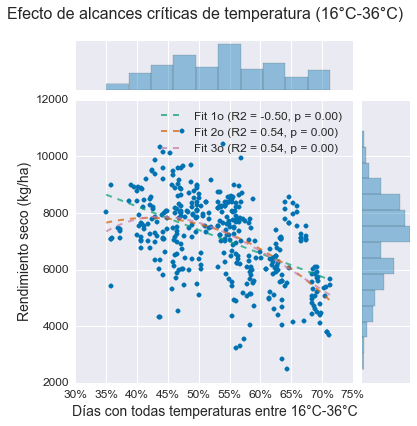

In [60]:
tmin, tmax = 16, 36
computar_clima_critical_frac(tmin, tmax)
sns.jointplot(df['clima_critical_frac'], df['rendimiento_seco_kg_ha'])
add_fit(df, 'clima_critical_frac','rendimiento_seco_kg_ha', range(1, 2 + ORDEN_FIT))
fig = plt.gcf()
ax = fig.get_axes()[0]
fig.subplots_adjust(left=0.2, top=0.9)
ax.set_xticklabels(['%.0f%%' % (p*100) for p in ax.get_xticks()])
ax.set_xlabel(u'Días con todas temperaturas entre %d°C-%d°C' % (tmin, tmax))
ax.set_ylabel('Rendimiento seco (kg/ha)')
fig.suptitle(u'Efecto de alcances críticas de temperatura (%d°C-%d°C)' % (tmin, tmax), fontsize=16)
fig.savefig('figuras/joint_temp_%d_%d_%dorden.png' % (tmin, tmax, ORDEN_FIT))